In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import numpy as np

In [2]:
electric = pd.read_csv('~/Downloads/Full+Eletric+Interval+042016.csv')

In [3]:
electric['Datetime'] = pd.to_datetime(electric['Date'] + ' ' + electric['Start Time'])

In [4]:
propertyCode = pd.read_excel('~/Downloads/SIMS_Property_List_4-6-2016_Revised.xlsx')

### Codes

In [5]:
codes = pd.Series([b[0] for b in electric['Meter'].str.split()])
unicodes = codes.unique()
unicodes = pd.Series(unicodes)

### Ages

In [6]:
agelst = []

for i in unicodes:
    agelst.append(propertyCode[propertyCode['Property Code'].isin([i])]['Year Constructed'])
age = pd.DataFrame(agelst).sum(axis=1)
age = age.reset_index(drop=True)

### Area

In [7]:
arealst = []
for b in unicodes:
    arealst.append(propertyCode[propertyCode['Property Code'].isin([b])]['FCIM Gross Area'])
area = pd.DataFrame(arealst).sum(axis=1)
area = area.reset_index(drop=True)

### Cumulative usage

In [8]:
clst = []
for i in unicodes:
    #for each unique code, find its Usage value in master df and add them all together, then append to list
    clst.append(electric.Usage[codes.isin([i])].sum())

In [9]:
clst

[3005098.9415982887,
 4625818.685999992,
 1718329.1399999908,
 2725629.599999804,
 7478261.948991606,
 3022492.463999999,
 11713764.348003576,
 1454910.515999986,
 19671990.50040677,
 1609801.3800000134,
 9693300.95820017,
 4234714.941999511,
 1964726.4618002344,
 388061.29619995796,
 213799.42599999835,
 215905.9077001192,
 1646120.9160002193,
 1525836.852000018,
 1675353.780000831,
 729598.5710000035,
 262225.0331999843,
 2436988.589999969,
 10029057.110200034,
 1730489.7270001862,
 387236.66400002036,
 17912123.251150467,
 5623665.119999974,
 13121073.067211233,
 1371034.728000003,
 1670372.3160000746,
 2856527.575202655,
 0.0,
 313588.29780000146,
 136908.83159999733,
 89824.05379997034,
 10711819.216009006,
 1131925.201200019,
 62490.17389999798,
 160069.66200001628,
 3413133.161999963,
 472039.8677999833,
 1081058.8800000031,
 8608299.093613252,
 2371863.4775998956,
 6917078.40000007,
 491797.0080000022,
 54698.526399957744,
 271786.71419958037,
 11216735.706607064,
 4877697.4200

### Full Building Names

In [10]:
namelst = []
for i in unicodes:
    namelst.append(propertyCode[propertyCode['Property Code'].isin([i])]['Property Name'])
namelst
name = pd.DataFrame(namelst)
name = name.replace(np.nan, '', regex=True)
name = name.reset_index(drop=True)
name =name.sum(axis=1)

### Normalized Usage

In [11]:
for i in clst:
    print(i/731)

4110.942464566742
6328.0693378932865
2350.655458276321
3728.631463748022
10230.18050477648
4134.736612859096
16024.301433657422
1990.3016634746732
26911.06771601473
2202.190670314656
13260.329628180807
5793.04369630576
2687.724297948337
530.8636062926921
292.475274965798
295.35691887841205
2251.875398085115
2087.3281149111053
2291.865636116048
998.082860465121
358.7209756497733
3333.7737209301904
13719.64036963069
2367.291008208189
529.7355184678801
24503.58857886521
7693.112339261251
17949.484360070088
1875.5605034199766
2285.051047879719
3907.6984612895417
0.0
428.9853595075259
187.28978331052986
122.87832257177885
14653.651458288654
1548.4612875513258
85.48587400820517
218.97354582765564
4669.128812585449
645.7453731873917
1478.8767168262698
11776.058951591316
3244.683279890418
9462.487551299686
672.772924760605
74.8269854992582
371.80125061502105
15344.37169166493
6672.636689466514
56.72482763337834
74605.95411216788
36557.13225718352
1293.3735710001868
16985.505467871702
48222.588

In [12]:
nusage = clst/area

In [13]:
data = {'Code': unicodes,'Building': name, 'Usage': clst, 'Area': area, 'Year': age, 'Normalized Usage': nusage}

In [14]:
cdf = pd.DataFrame(data)
cdf['Building'] = cdf['Code'] + " " + cdf['Building']

In [15]:
ccodes = []
for i in cdf['Code']:
    ccodes.append(i)
ccodes = pd.Series(ccodes)


### Functions

In [16]:
def graphGroup(name):
    namepc = propertyCode[propertyCode['Building Use'].str.contains(name, na=False)]
    dflst = []
    for i in namepc['Property Code']:
        dflst.append(i)
    df = cdf[ccodes.isin(dflst)]
    df = df.reset_index(drop=True)
    df = df[df != 0]
    df.loc[-1] = [df['Area'].sum()/(len(df['Area'])), "avg", "Average", df['Normalized Usage'].sum()/(len(df['Normalized Usage'])), df['Usage'].sum()/(len(df['Usage'])), df['Year'].sum()/(len(df['Year']))] 
    return df

In [17]:
def graphAny(code, view):
    meterdf = electric[codes.isin([code])].groupby(by=['Datetime']).sum()
    meterdf = meterdf.reset_index()
    if view == 'month':
        meterdf.Datetime = meterdf.Datetime.dt.month
    elif view == 'day':
        meterdf.Datetime = meterdf.Datetime.dt.weekday
    elif view == 'time':        
        meterdf.Datetime = meterdf.Datetime.dt.time
    meterdf = meterdf.groupby(by=['Datetime']).mean()
    meterdf.plot(y='Usage', kind='bar', figsize=(20, 3))

In [18]:
def graphAnyMeter(code, view):
    meterdf = electric[codes.isin([code])]
    if view == 'month':
        meterdf.Datetime = meterdf.Datetime.dt.month
    elif view == 'day':
        meterdf.Datetime = meterdf.Datetime.dt.weekday
    elif view == 'time':
        meterdf.Datetime = meterdf.Datetime.dt.time
    meterdf = meterdf.groupby(by=['Meter', 'Datetime']).mean()
    meterdf.groupby(by='Meter').plot.bar(y='Usage', figsize=(20,3))
    plt.ylabel('Usage (kWh)')
    plt.title(code)

### Dorm data

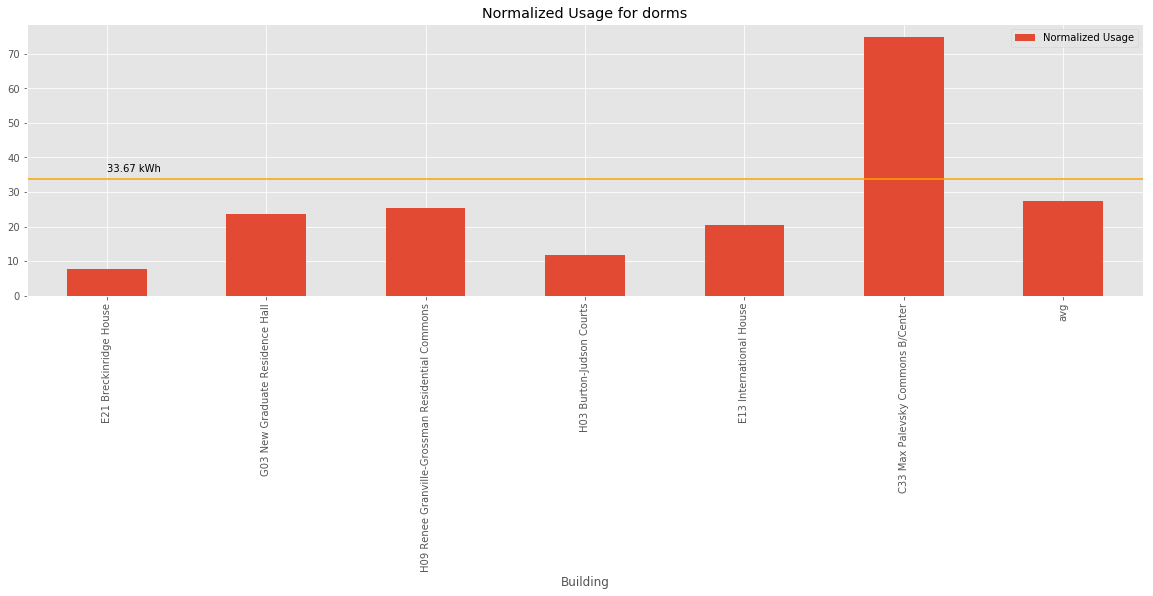

In [19]:
dormdf = graphGroup('Dorm')
dormdf.plot(x='Building', y='Normalized Usage', kind='bar', figsize=(20, 5)).annotate("33.67 kWh",(0, 36))
plt.axhline(y=33.67, color='orange')
plt.title('Normalized Usage for dorms')

In [20]:
dormdf['Cumulative usage'] = dormdf['Usage']
dormdf

,Area,Building,Code,Normalized Usage,Usage,Year,Cumulative usage
0,50697.420000,E21 Breckinridge House,E21,7.654458,3.880613e+05,1916.000000,3.880613e+05
1,121452.480000,G03 New Graduate Residence Hall,G03,23.519714,2.856528e+06,1963.000000,2.856528e+06
2,338679.330000,H09 Renee Granville-Grossman Residential Commons,H09,25.417256,8.608299e+06,2009.000000,8.608299e+06
3,201402.160000,H03 Burton-Judson Courts,H03,11.776753,2.371863e+06,1931.000000,2.371863e+06
4,237120.340000,E13 International House,E13,20.570557,4.877697e+06,1932.000000,4.877697e+06
5,95682.000000,C33 Max Palevsky Commons B/Center,C33,74.855636,7.162337e+06,2002.000000,7.162337e+06
-1,174172.288333,avg,Average,27.299062,4.377464e+06,1958.833333,4.377464e+06


In [21]:
dormdf['Usage'] = dormdf['Usage']/731
dormdf

,Area,Building,Code,Normalized Usage,Usage,Year,Cumulative usage
0,50697.420000,E21 Breckinridge House,E21,7.654458,530.863606,1916.000000,3.880613e+05
1,121452.480000,G03 New Graduate Residence Hall,G03,23.519714,3907.698461,1963.000000,2.856528e+06
2,338679.330000,H09 Renee Granville-Grossman Residential Commons,H09,25.417256,11776.058952,2009.000000,8.608299e+06
3,201402.160000,H03 Burton-Judson Courts,H03,11.776753,3244.683280,1931.000000,2.371863e+06
4,237120.340000,E13 International House,E13,20.570557,6672.636689,1932.000000,4.877697e+06
5,95682.000000,C33 Max Palevsky Commons B/Center,C33,74.855636,9797.998550,2002.000000,7.162337e+06
-1,174172.288333,avg,Average,27.299062,5988.323256,1958.833333,4.377464e+06


In [22]:
dormdf['Normalized Usage'] = dormdf['Usage']/dormdf['Area']
dormdf

,Area,Building,Code,Normalized Usage,Usage,Year,Cumulative usage
0,50697.420000,E21 Breckinridge House,E21,0.010471,530.863606,1916.000000,3.880613e+05
1,121452.480000,G03 New Graduate Residence Hall,G03,0.032175,3907.698461,1963.000000,2.856528e+06
2,338679.330000,H09 Renee Granville-Grossman Residential Commons,H09,0.034771,11776.058952,2009.000000,8.608299e+06
3,201402.160000,H03 Burton-Judson Courts,H03,0.016110,3244.683280,1931.000000,2.371863e+06
4,237120.340000,E13 International House,E13,0.028140,6672.636689,1932.000000,4.877697e+06
5,95682.000000,C33 Max Palevsky Commons B/Center,C33,0.102402,9797.998550,2002.000000,7.162337e+06
-1,174172.288333,avg,Average,0.034382,5988.323256,1958.833333,4.377464e+06


In [23]:
poplst = [90, 200, 800,300, 500, 700, 432]

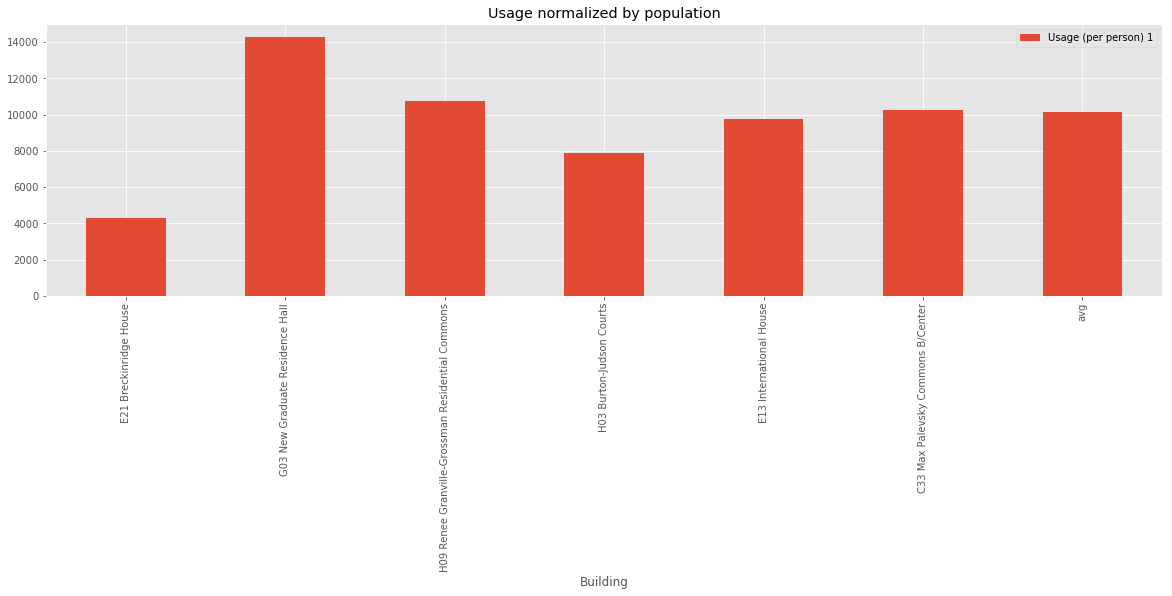

In [24]:
dormdf['Usage (per person) 1'] = dormdf['Cumulative usage']/poplst
dax = dormdf.plot(x='Building', y='Usage (per person) 1', kind='bar', figsize=(20,5))
plt.title('Usage normalized by population')

In [25]:
dormdf['Usage (per person)'] = dormdf['Usage']/poplst

In [26]:
dormdf

,Area,Building,Code,Normalized Usage,Usage,Year,Cumulative usage,Usage (per person) 1,Usage (per person)
0,50697.420000,E21 Breckinridge House,E21,0.010471,530.863606,1916.000000,3.880613e+05,4311.792180,5.898485
1,121452.480000,G03 New Graduate Residence Hall,G03,0.032175,3907.698461,1963.000000,2.856528e+06,14282.637876,19.538492
2,338679.330000,H09 Renee Granville-Grossman Residential Commons,H09,0.034771,11776.058952,2009.000000,8.608299e+06,10760.373867,14.720074
3,201402.160000,H03 Burton-Judson Courts,H03,0.016110,3244.683280,1931.000000,2.371863e+06,7906.211592,10.815611
4,237120.340000,E13 International House,E13,0.028140,6672.636689,1932.000000,4.877697e+06,9755.394840,13.345273
5,95682.000000,C33 Max Palevsky Commons B/Center,C33,0.102402,9797.998550,2002.000000,7.162337e+06,10231.909914,13.997141
-1,174172.288333,avg,Average,0.034382,5988.323256,1958.833333,4.377464e+06,10133.019214,13.861859


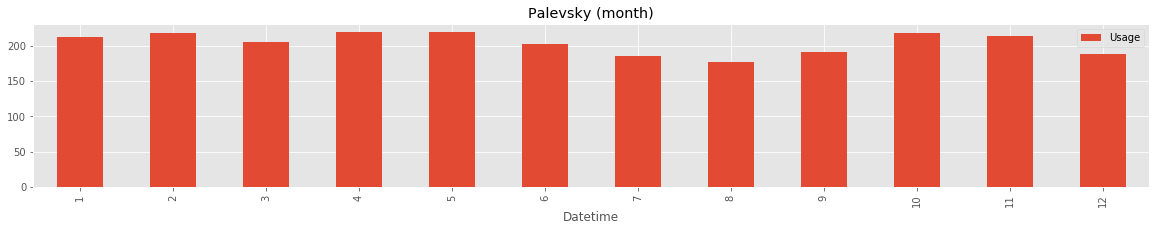

In [27]:
graphAny('C33', 'month')
plt.title('Palevsky (month)')

/Users/abisolaolawale/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


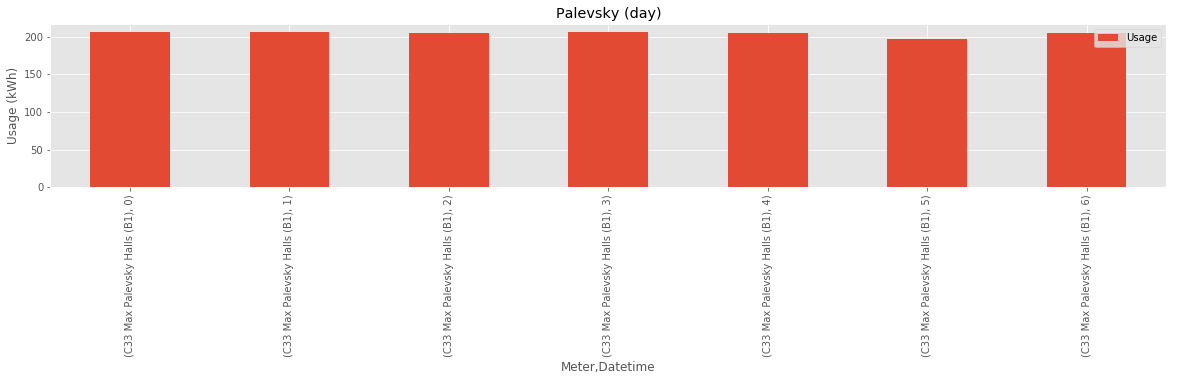

In [28]:
graphAnyMeter('C33', 'day')
plt.title('Palevsky (day)')

In [29]:
dormdf

,Area,Building,Code,Normalized Usage,Usage,Year,Cumulative usage,Usage (per person) 1,Usage (per person)
0,50697.420000,E21 Breckinridge House,E21,0.010471,530.863606,1916.000000,3.880613e+05,4311.792180,5.898485
1,121452.480000,G03 New Graduate Residence Hall,G03,0.032175,3907.698461,1963.000000,2.856528e+06,14282.637876,19.538492
2,338679.330000,H09 Renee Granville-Grossman Residential Commons,H09,0.034771,11776.058952,2009.000000,8.608299e+06,10760.373867,14.720074
3,201402.160000,H03 Burton-Judson Courts,H03,0.016110,3244.683280,1931.000000,2.371863e+06,7906.211592,10.815611
4,237120.340000,E13 International House,E13,0.028140,6672.636689,1932.000000,4.877697e+06,9755.394840,13.345273
5,95682.000000,C33 Max Palevsky Commons B/Center,C33,0.102402,9797.998550,2002.000000,7.162337e+06,10231.909914,13.997141
-1,174172.288333,avg,Average,0.034382,5988.323256,1958.833333,4.377464e+06,10133.019214,13.861859


### Cornell Dorm Data

In [30]:
def cleanData(df):
    df = df.drop('Unnamed: 0', axis=1)
    data = {'Datetime': df['Datetime'], 'Usage': df['Usage']}
    df2 = pd.DataFrame(data)
    df2['Datetime'] = pd.to_datetime(df2['Datetime'])
    return df2

In [31]:
def concat_data(path1, path2, name):
    df = pd.read_csv('~/Downloads/Cornell Dorm Data/'+path1)
    df2 = pd.read_csv('~/Downloads/Cornell Dorm Data/'+path2)
    df['Datetime'] = df['Unnamed: 0']
    df2['Datetime'] = df2['Unnamed: 0']
    df['Usage'] = df[df.columns[1]]
    df2['Usage'] = df2[df2.columns[1]]
    df['Building'] = name
    df2['Building'] = name
    data = {'Building': df['Building'], 'Usage': df['Usage'], 'Datetime': df['Datetime']} 
    data2 = {'Building': df2['Building'], 'Usage': df2['Usage'], 'Datetime': df2['Datetime']}
    _df = pd.DataFrame(data)
    _df2 = pd.DataFrame(data2)
    _df['Datetime'] = pd.to_datetime(_df['Datetime'])
    _df2['Datetime'] = pd.to_datetime(_df2['Datetime'])
    _df = _df.replace({'nodata': 0}, regex=True)
    _df2 = _df2.replace({'nodata':0}, regex=True)
    combined = pd.concat([_df, _df2])
    combined = combined.reset_index(drop=True)
    combined['Usage'] = pd.to_numeric(combined['Usage'])
    return combined

In [32]:
donlondf = concat_data('MaryDonlon (14-15).csv', 'MaryDonlon (15-16).csv', 'Mary Donlon')
floradf = concat_data('Flora Rose (14-15).csv', 'Flora Rose (15-16).csv', 'Flora Rose')
williamdf = concat_data('William Keeton (14-15).csv', 'William Keeton (15-16).csv', 'William Keeton')
hansdf = concat_data('Hans Bethe (14-15).csv', 'Hans Bethe (15-16).csv', 'Hans Bethe')
carldf = concat_data('Carl Becker (14-15).csv', 'Carl Becker (15-16).csv', 'Carl Becker')
cookdf = concat_data('Alice Cook (14-15).csv', 'Alice Cook (15-16).csv', 'Alice Cook')
sheldondf = concat_data('Sheldon Court (14-15).csv', 'Sheldon Court (15-16).csv', 'Sheldon Court')
cascadilladf = concat_data('Cascadilla (14-15).csv', 'Cascadilla (15-16).csv', 'Cascadilla')
dicksondf = concat_data('Clara Dickson (14-15).csv', 'Clara Dickson (15-16).csv', 'Clara Dickson')
balchdf = concat_data('Balch Hall (14-15).csv', 'Balch Hall (15-16).csv', 'Balch Hall')

In [33]:
clst=[]
def cumulative(df):
    csum = df['Usage'].sum()
    clst.append(csum)

In [34]:
cumulative(donlondf)
cumulative(floradf)
cumulative(hansdf)
cumulative(carldf)
cumulative(cookdf)
cumulative(sheldondf)
cumulative(cascadilladf)
cumulative(dicksondf)
cumulative(balchdf)

In [35]:
arealst = [133594, 83141, 142901, 169290, 78438, 48881, 98624, 168791, 166814]

In [36]:
namelst = ['Mary Donlon', 'Flora Rose', 'Hans Bethe', 'Carl Becker', 'Alice Cook',
          'Sheldon Court', 'Cascadilla', 'Clara Dickson', 'Balch Hall']

In [37]:
data = {'Building': namelst, 'Usage': clst, 'Area': arealst}

In [38]:
cornell_dormdf = pd.DataFrame(data)
cornell_dormdf['Normalized Usage'] = cornell_dormdf['Usage']/cornell_dormdf['Area']

/Users/abisolaolawale/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/abisolaolawale/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


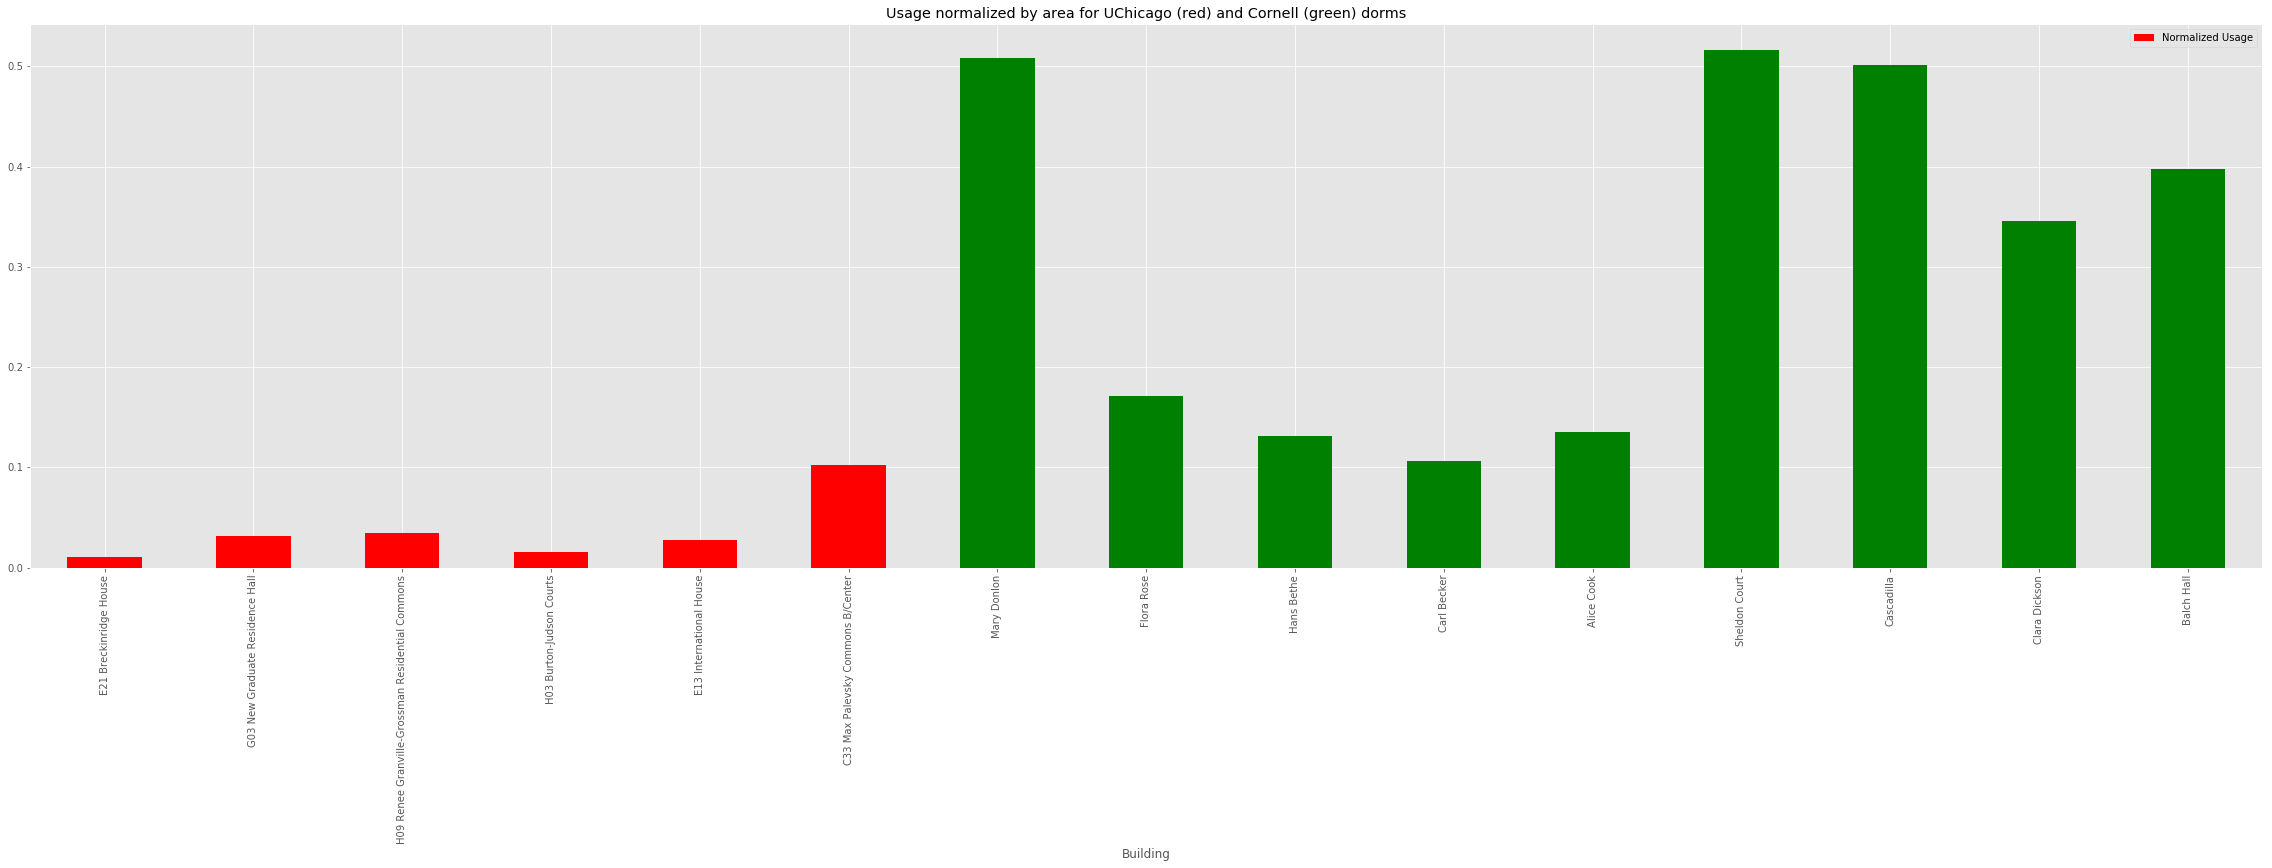

In [39]:
cornell_dormdf
combined_dormdf = pd.concat([dormdf, cornell_dormdf])
combined_dormdf
combined_dormdf = combined_dormdf.drop([-1], axis=0).reset_index(drop=True)
combined_dormdf['Group'] = None
combined_dormdf['Group'][0:6] = 1
combined_dormdf['Group'][6:] = 2
colors = {1: 'red', 2: 'green'}
combined_dormdf.plot(x='Building', y='Normalized Usage', kind='bar', color=[colors[i] for i in combined_dormdf['Group']], figsize=(40, 10))
plt.title('Usage normalized by area for UChicago (red) and Cornell (green) dorms')

In [40]:
combined_dormdf

,Area,Building,Code,Cumulative usage,Normalized Usage,Usage,Usage (per person),Usage (per person) 1,Year,Group
0,50697.42,E21 Breckinridge House,E21,3.880613e+05,0.010471,530.863606,5.898485,4311.792180,1916.0,1
1,121452.48,G03 New Graduate Residence Hall,G03,2.856528e+06,0.032175,3907.698461,19.538492,14282.637876,1963.0,1
2,338679.33,H09 Renee Granville-Grossman Residential Commons,H09,8.608299e+06,0.034771,11776.058952,14.720074,10760.373867,2009.0,1
3,201402.16,H03 Burton-Judson Courts,H03,2.371863e+06,0.016110,3244.683280,10.815611,7906.211592,1931.0,1
4,237120.34,E13 International House,E13,4.877697e+06,0.028140,6672.636689,13.345273,9755.394840,1932.0,1
5,95682.00,C33 Max Palevsky Commons B/Center,C33,7.162337e+06,0.102402,9797.998550,13.997141,10231.909914,2002.0,1
6,133594.00,Mary Donlon,NaN,NaN,0.508529,67936.407581,NaN,NaN,NaN,2
7,83141.00,Flora Rose,NaN,NaN,0.171163,14230.630039,NaN,NaN,NaN,2
8,142901.00,Hans Bethe,NaN,NaN,0.131134,18739.238099,NaN,NaN,NaN,2
9,169290.00,Carl Becker,NaN,NaN,0.106831,18085.428628,NaN,NaN,NaN,2


In [41]:
combined_dormdf

,Area,Building,Code,Cumulative usage,Normalized Usage,Usage,Usage (per person),Usage (per person) 1,Year,Group
0,50697.42,E21 Breckinridge House,E21,3.880613e+05,0.010471,530.863606,5.898485,4311.792180,1916.0,1
1,121452.48,G03 New Graduate Residence Hall,G03,2.856528e+06,0.032175,3907.698461,19.538492,14282.637876,1963.0,1
2,338679.33,H09 Renee Granville-Grossman Residential Commons,H09,8.608299e+06,0.034771,11776.058952,14.720074,10760.373867,2009.0,1
3,201402.16,H03 Burton-Judson Courts,H03,2.371863e+06,0.016110,3244.683280,10.815611,7906.211592,1931.0,1
4,237120.34,E13 International House,E13,4.877697e+06,0.028140,6672.636689,13.345273,9755.394840,1932.0,1
5,95682.00,C33 Max Palevsky Commons B/Center,C33,7.162337e+06,0.102402,9797.998550,13.997141,10231.909914,2002.0,1
6,133594.00,Mary Donlon,NaN,NaN,0.508529,67936.407581,NaN,NaN,NaN,2
7,83141.00,Flora Rose,NaN,NaN,0.171163,14230.630039,NaN,NaN,NaN,2
8,142901.00,Hans Bethe,NaN,NaN,0.131134,18739.238099,NaN,NaN,NaN,2
9,169290.00,Carl Becker,NaN,NaN,0.106831,18085.428628,NaN,NaN,NaN,2


In [42]:
cornell_poplst = [450, 360, 375, 350, 350, 164, 366, 460, 230]

In [43]:
combined_dormdf['Usage (per person)'][6:] = combined_dormdf['Usage'][6:]/cornell_poplst
combined_dormdf

/Users/abisolaolawale/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Area,Building,Code,Cumulative usage,Normalized Usage,Usage,Usage (per person),Usage (per person) 1,Year,Group
0,50697.42,E21 Breckinridge House,E21,3.880613e+05,0.010471,530.863606,5.898485,4311.792180,1916.0,1
1,121452.48,G03 New Graduate Residence Hall,G03,2.856528e+06,0.032175,3907.698461,19.538492,14282.637876,1963.0,1
2,338679.33,H09 Renee Granville-Grossman Residential Commons,H09,8.608299e+06,0.034771,11776.058952,14.720074,10760.373867,2009.0,1
3,201402.16,H03 Burton-Judson Courts,H03,2.371863e+06,0.016110,3244.683280,10.815611,7906.211592,1931.0,1
4,237120.34,E13 International House,E13,4.877697e+06,0.028140,6672.636689,13.345273,9755.394840,1932.0,1
5,95682.00,C33 Max Palevsky Commons B/Center,C33,7.162337e+06,0.102402,9797.998550,13.997141,10231.909914,2002.0,1
6,133594.00,Mary Donlon,NaN,NaN,0.508529,67936.407581,150.969795,NaN,NaN,2
7,83141.00,Flora Rose,NaN,NaN,0.171163,14230.630039,39.529528,NaN,NaN,2
8,142901.00,Hans Bethe,NaN,NaN,0.131134,18739.238099,49.971302,NaN,NaN,2
9,169290.00,Carl Becker,NaN,NaN,0.106831,18085.428628,51.672653,NaN,NaN,2


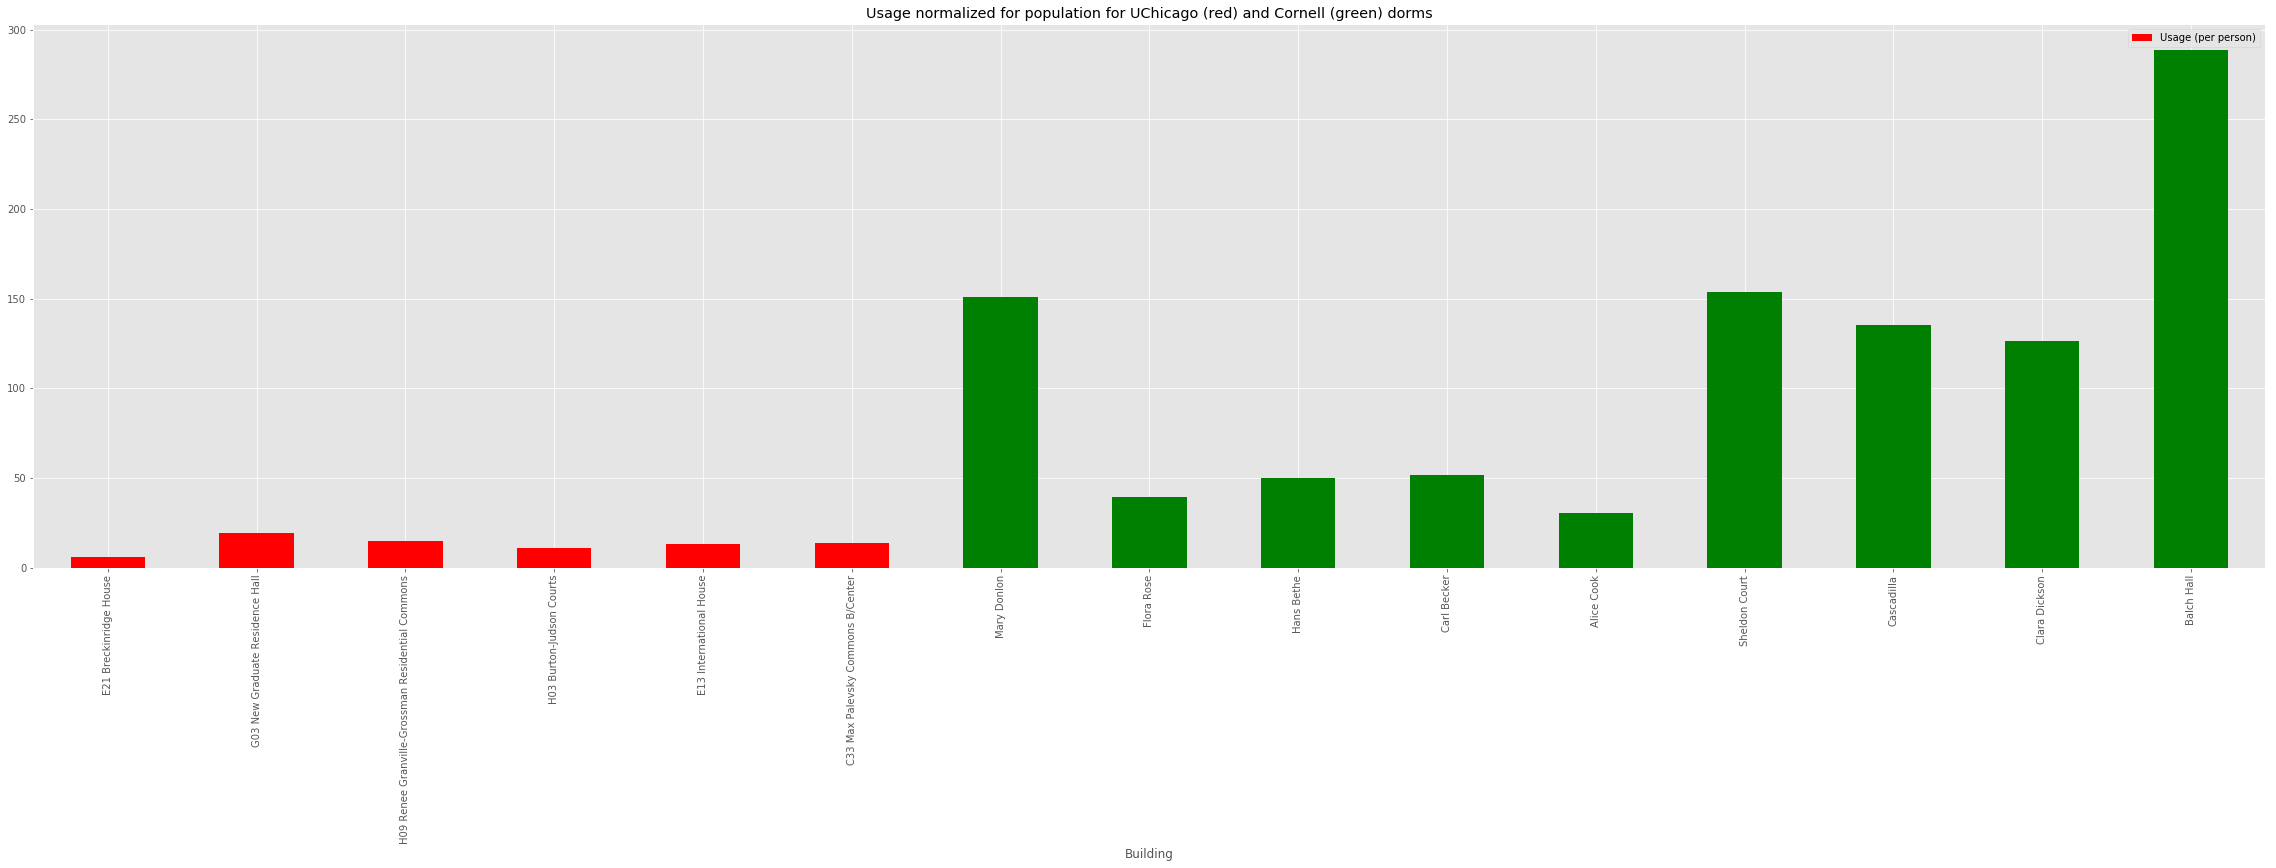

In [44]:
combined_dormdf.plot(x='Building', y='Usage (per person)', kind='bar', color=[colors[i] for i in combined_dormdf['Group']], figsize=(40, 10))
plt.title('Usage normalized for population for UChicago (red) and Cornell (green) dorms')


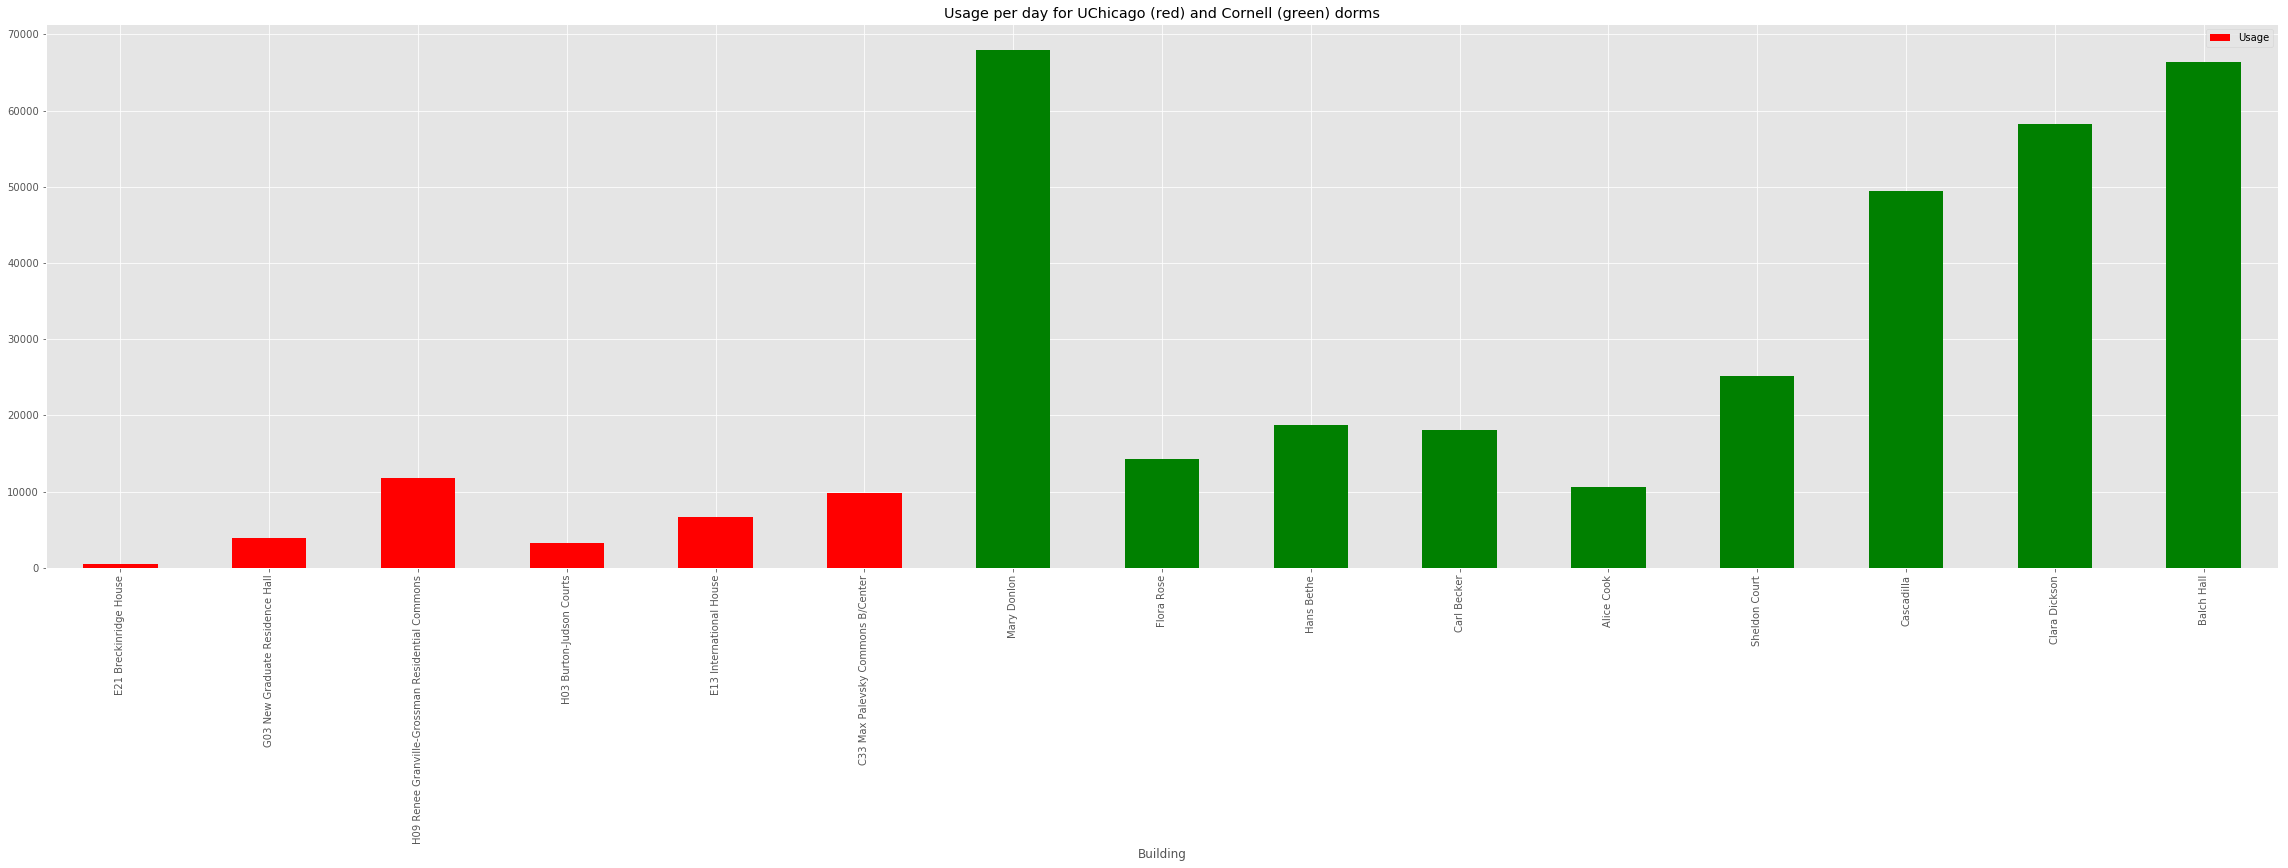

In [46]:
combined_dormdf.plot(x='Building', y='Usage', kind='bar', color=[colors[i] for i in combined_dormdf['Group']], figsize=(40, 10))
plt.title('Usage per day for UChicago (red) and Cornell (green) dorms')